In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=24

train_cardiac_total=pd.read_csv("mimic_ca_vital_sign_combine_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_ca_vital_sign_combine_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_ca_baseline_total_v2.csv")

total_train=21540 #control+event
total_test=5384 #control+event
train_control=21160 #control

var=76
random=32
smote_ratio=1
near_ratio=1
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_total=train_cardiac_total.drop(['subject_id'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['stay_id'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['indextime'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['date'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['hours_diff'],axis=1)
train_cardiac_total=train_cardiac_total.drop(['event'],axis=1)

test_cardiac_total=test_cardiac_total.drop(['subject_id'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['stay_id'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['indextime'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['date'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['hours_diff'],axis=1)
test_cardiac_total=test_cardiac_total.drop(['event'],axis=1)

#train_cardiac_total=train_cardiac_total.drop(['hadm_id'],axis=1)
#train_cardiac_total=train_cardiac_total.drop(['stay_id'],axis=1)
#train_cardiac_total=train_cardiac_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_total=pd.get_dummies(data=train_cardiac_total,columns=["first_careunit","ethnicity"])
test_cardiac_total=pd.get_dummies(data=test_cardiac_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

#x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

#train_cardiac_total=train_cardiac_total.drop(['eventV3'],axis=1)

train_cardiac_total=train_cardiac_total.values  
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total.values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

#x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

#x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

print('timeline:',train_cardiac_total.shape)
print('timeline:',x_train_lstm.shape)
print('label:',y_train.shape)

#print('timeline:',test_cardiac_total.shape)
print('timeline:',x_test_lstm.shape)
print('label:',y_test.shape)

#print('timeline_no_smote:',x_train_lstm_no_smote.shape)
#print('label_no_smote:',y_train_no_smote.shape)

#print('timeline_nr:',x_train_lstm_nr.shape)
#print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


Using TensorFlow backend.


timeline: (21540, 1824)
timeline: (42320, 24, 76)
label: (42320,)
timeline: (5384, 24, 76)
label: (5384, 1)


In [2]:
test_cardiac_total.columns

Index(['vHR', 'vRR', 'vsbp', 'vdbp', 'vmbp', 'vspo2', 'age', 'female',
       'congestive_heart_failure', 'cardiac_arrhythmias', 'valvular_disease',
       'pulmonary_circulation', 'peripheral_vascular',
       'uncomplicated_hypertension', 'complicated_hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression', 'mvar1', 'mvar2', 'mvar3',
       'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9', 'mvar10',
       'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23',
       'first_careunit

In [3]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(42320, 24, 76)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 8)             2720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 8)             0         
___________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 38s - loss: 0.3978 - accuracy: 0.8367 - f1_m: 0.7728 - precision_m: 0.8014 - val_loss: 1.1620 - val_accuracy: 0.3958 - val_f1_m: 0.5611 - val_precision_m: 1.0000
Epoch 3/3
 - 47s - loss: 0.3689 - accuracy: 0.8488 - f1_m: 0.7921 - precision_m: 0.8098 - val_loss: 0.6146 - val_accuracy: 0.6115 - val_f1_m: 0.7552 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 143.55 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 78.9627%
test accuracy = 96.601%
test error = 183 out of 5384 examples


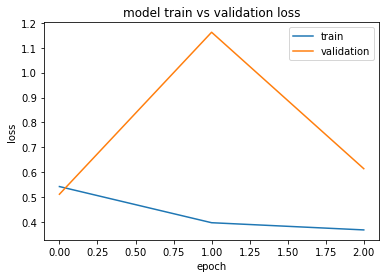

In [4]:
from matplotlib import pyplot 

pyplot.plot(History.history['loss']) 
pyplot.plot(History.history['val_loss']) 
pyplot.title('model train vs validation loss') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [5]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 1 0 0]


In [6]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5144  145]
 [  38   57]]
accuracy: 0.9660104011887073
specificity: 0.9725846095670259
sensitivity: 0.6
ppv: 0.28217821782178215
npv: 0.99266692396758


<Figure size 432x288 with 0 Axes>

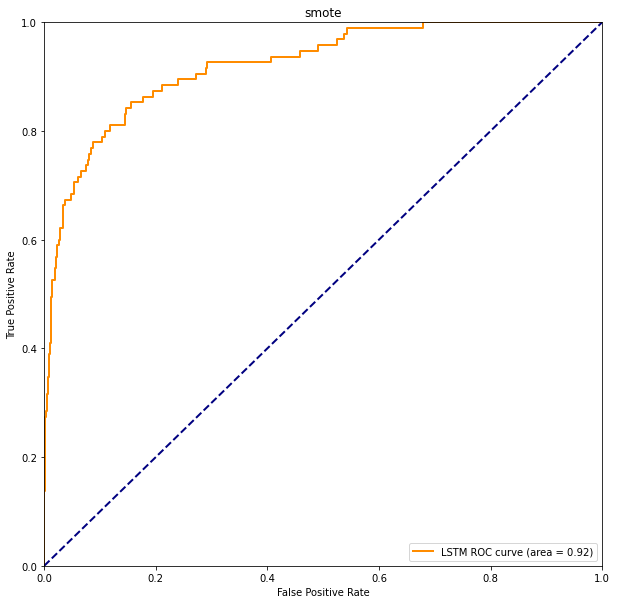

In [7]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [8]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_1 = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 24, 76)
(8464, 24, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 8)             2720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 8)             0         
____________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 37s - loss: 0.4029 - accuracy: 0.8464 - f1_m: 0.8461 - precision_m: 0.8397 - val_loss: 0.4370 - val_accuracy: 0.7953 - val_f1_m: 0.3859 - val_precision_m: 0.5019
Epoch 3/3
 - 40s - loss: 0.3859 - accuracy: 0.8448 - f1_m: 0.8452 - precision_m: 0.8316 - val_loss: 0.4095 - val_accuracy: 0.7814 - val_f1_m: 0.3713 - val_precision_m: 0.5019
-----------------------------------------------------------------
Training was completed in 155.92 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 77.4043%
test accuracy = 96.4525%
test error = 191 out of 5384 examples


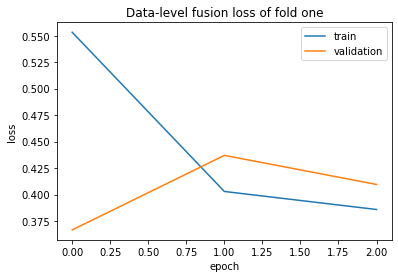

In [9]:
from matplotlib import pyplot 

pyplot.plot(History_1.history['loss']) 
pyplot.plot(History_1.history['val_loss']) 
pyplot.title('Data-level fusion loss of fold one') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [10]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 1 0 0]


In [11]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5137  152]
 [  39   56]]
specificity: 0.9712611079599168
sensitivity: 0.5894736842105263
ppv: 0.2692307692307692
npv: 0.9924652241112828


In [12]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_2 = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 24, 76)
(8464, 24, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 24, 8)             2720      
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 8)             0         
____________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 39s - loss: 0.4343 - accuracy: 0.8337 - f1_m: 0.8323 - precision_m: 0.8295 - val_loss: 0.3684 - val_accuracy: 0.8613 - val_f1_m: 0.4798 - val_precision_m: 0.5017
Epoch 3/3
 - 39s - loss: 0.3961 - accuracy: 0.8481 - f1_m: 0.8487 - precision_m: 0.8353 - val_loss: 0.3805 - val_accuracy: 0.8569 - val_f1_m: 0.4910 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 134.36 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 85.843%
test accuracy = 74.7957%
test error = 1357 out of 5384 examples


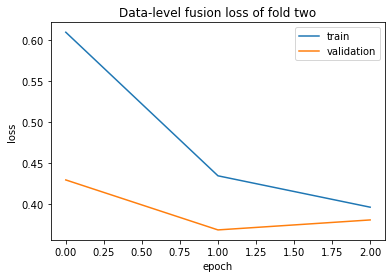

In [13]:
from matplotlib import pyplot 

pyplot.plot(History_2.history['loss']) 
pyplot.plot(History_2.history['val_loss']) 
pyplot.title('Data-level fusion loss of fold two') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [14]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[1 0 0 ... 1 1 1]


In [15]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3943 1346]
 [  11   84]]
specificity: 0.745509548118737
sensitivity: 0.8842105263157894
ppv: 0.05874125874125874
npv: 0.9972180070814365


In [16]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_3 = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 24, 76)
(8464, 24, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 8)             2720      
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 8)             0         
____________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 39s - loss: 0.4598 - accuracy: 0.8055 - f1_m: 0.7968 - precision_m: 0.8269 - val_loss: 0.4798 - val_accuracy: 0.7824 - val_f1_m: 0.4953 - val_precision_m: 0.5014
Epoch 3/3
 - 40s - loss: 0.4097 - accuracy: 0.8314 - f1_m: 0.8324 - precision_m: 0.8198 - val_loss: 0.4088 - val_accuracy: 0.8333 - val_f1_m: 0.4851 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 136.66 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 82.718%
test accuracy = 72.4183%
test error = 1485 out of 5384 examples


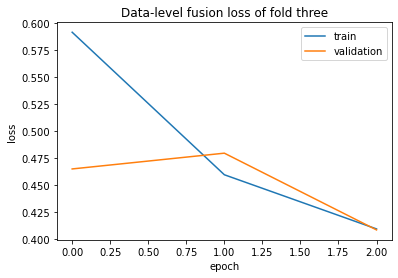

In [17]:
from matplotlib import pyplot 

pyplot.plot(History_3.history['loss']) 
pyplot.plot(History_3.history['val_loss']) 
pyplot.title('Data-level fusion loss of fold three') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [18]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 1 0 ... 1 1 0]


In [19]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3821 1468]
 [  17   78]]
specificity: 0.722442805823407
sensitivity: 0.8210526315789474
ppv: 0.050452781371280724
npv: 0.9955706096925482


In [20]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_4 = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 24, 76)
(8464, 24, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 8)             2720      
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_14 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 8)             0         
____________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 39s - loss: 0.4383 - accuracy: 0.8221 - f1_m: 0.8217 - precision_m: 0.8153 - val_loss: 1.0878 - val_accuracy: 0.5004 - val_f1_m: 0.5013 - val_precision_m: 0.5009
Epoch 3/3
 - 37s - loss: 0.3912 - accuracy: 0.8463 - f1_m: 0.8474 - precision_m: 0.8327 - val_loss: 1.2878 - val_accuracy: 0.5000 - val_f1_m: 0.5013 - val_precision_m: 0.5009
-----------------------------------------------------------------
Training was completed in 126.84 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.0%
test accuracy = 1.7645%
test error = 5289 out of 5384 examples


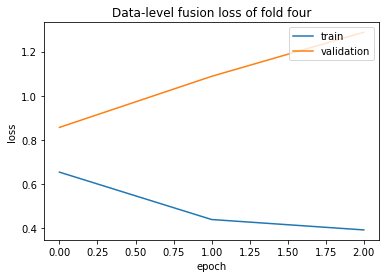

In [21]:
from matplotlib import pyplot 

pyplot.plot(History_4.history['loss']) 
pyplot.plot(History_4.history['val_loss']) 
pyplot.title('Data-level fusion loss of fold four') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [22]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[1 1 1 ... 1 1 1]


In [23]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[   0 5289]
 [   0   95]]
specificity: 0.0
sensitivity: 1.0
ppv: 0.01764487369985141
npv: nan


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


In [24]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History_5 = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 24, 76)
(8464, 24, 76)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 24, features = 76, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 8)             2720      
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 8)             0         
____________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 32s - loss: 0.4106 - accuracy: 0.8377 - f1_m: 0.8374 - precision_m: 0.8306 - val_loss: 0.9292 - val_accuracy: 0.5919 - val_f1_m: 0.1574 - val_precision_m: 0.5019
Epoch 3/3
 - 30s - loss: 0.3848 - accuracy: 0.8438 - f1_m: 0.8448 - precision_m: 0.8323 - val_loss: 1.0077 - val_accuracy: 0.5467 - val_f1_m: 0.0850 - val_precision_m: 0.4906
-----------------------------------------------------------------
Training was completed in 105.80 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 55.0922%
test accuracy = 98.2727%
test error = 93 out of 5384 examples


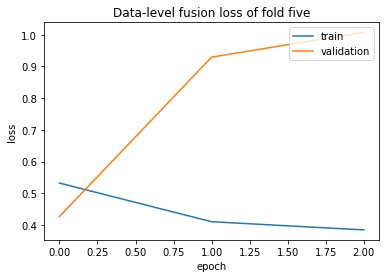

In [25]:
from matplotlib import pyplot 

pyplot.plot(History_5.history['loss']) 
pyplot.plot(History_5.history['val_loss']) 
pyplot.title('Data-level fusion loss of fold five') 
pyplot.ylabel('loss') 
pyplot.xlabel('epoch') 
pyplot.legend(['train','validation'],loc='upper right') 
pyplot.show() 


In [26]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 0 0 ... 0 0 0]


In [27]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5281    8]
 [  85   10]]
specificity: 0.9984874267347325
sensitivity: 0.10526315789473684
ppv: 0.5555555555555556
npv: 0.9841595229221021


In [28]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [29]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 1 1 0]


In [30]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[4555  734]
 [  18   77]]
specificity: 0.8612214029117036
sensitivity: 0.8105263157894737
ppv: 0.09494451294697903
npv: 0.8612214029117036


<Figure size 432x288 with 0 Axes>

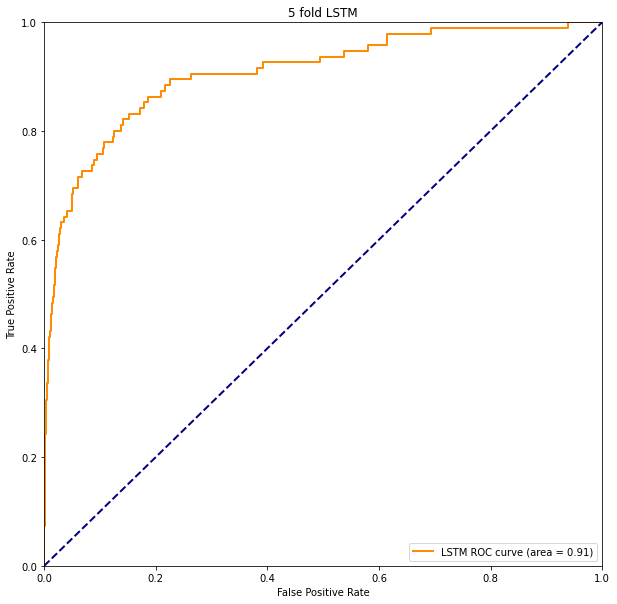

In [31]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [32]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.86
AUC : 0.91
Sensitivity : 0.81
Specificity :0.86
60.39920487474425


In [33]:
y_pred

array([0.42621693, 0.4191997 , 0.24248116, ..., 0.8296174 , 0.6085573 ,
       0.49794704], dtype=float32)